In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time

import phdequinox.sim_drifter as sdr

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [7]:
client

Client Scheduler: tcp://10.148.1.43:32808 Dashboard: http://10.148.1.43:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


---

## load data

In [5]:
#root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
root_path = '/home/c11-data/Test_aponte/jetn/'

run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

# !!!
L=1026 # check this parameter, corresponds to the x period 

In [17]:
## New methods

def time_window_processing(df, myfun, columns, T, N, overlap=0.5, **myfun_kwargs):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    tmin, tmax = p.index[0], p.index[-1]
    # need to create an empty dataframe, in case the loop below is empty
    myfun_out = myfun(*[None for c in columns], N, **myfun_kwargs) # get index from fake output
    index = ['x','y']+list(myfun_out.index)
    out = [pd.DataFrame({_:[] for _ in index})]
    t=tmin
    while t+T<tmax:
        #
        _p = p.loc[t:t+T]
        # compute average position
        x, y = sdr.mean_position(_p, L)
        # apply myfun
        myfun_out = myfun(*[_p[c] for c in columns], N, **myfun_kwargs)
        # combine with mean position and time
        _out = pd.DataFrame([[x, y]+list(myfun_out)],
                            columns = index,
                            index = [t+T/2.])
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

In [17]:
def apply_twin_processing(dr, *args, **kwargs):
    ''' apply time_window_processing to dr.df and reset index properly
    '''
    df = dr.df.groupby(['id']).apply(time_window_processing, get_spectrum, ['u'], T, int(T/dt/2), dt=dt)
    _reset_index = lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
    return df.map_partitions(_reset_index)

In [6]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [9]:
dr

     id       time      xgrid      ygrid  zgrid     depth       temp  \
0  7161  1500.0069  196.40944  541.79652   50.0 -0.935944  25.886666   
1  7162  1500.0069  196.40937  543.30184   50.0 -0.940022  25.885229   
2  7163  1500.0069  196.40946  544.80716   50.0 -0.944117  25.884374   
3  7164  1500.0069  196.40961  546.31250   50.0 -0.948345  25.884627   
4  7165  1500.0069  196.40971  547.81780   50.0 -0.952706  25.885603   

          u         v          dudt          dvdt      pres          x  \
0  0.058079 -0.105506 -5.820925e-08  3.420817e-07 -8.260263  785.63776   
1  0.057283 -0.101750 -2.034746e-08  3.515808e-07 -8.300321  785.63748   
2  0.058512 -0.097537 -1.201106e-09  3.599363e-07 -8.340519  785.63784   
3  0.060480 -0.093268 -1.958836e-08  3.627984e-07 -8.381996  785.63844   
4  0.061626 -0.089432 -6.096121e-08  3.575484e-07 -8.424740  785.63884   

            y  
0  2167.18608  
1  2173.20736  
2  2179.22864  
3  2185.25000  
4  2191.27120  

### load one drifter time series for tests

In [10]:
df = dr.df.groupby(['id']).get_group(225).compute()
df

,id,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
214868,225,1570.8264,64.540791,506.31536,50.0,-0.253142,25.732828,0.202881,0.033091,0.000018,-0.000011,-1.567594,258.163164,2025.26144
215194,225,1570.8333,64.574002,506.32280,50.0,-0.257412,25.733086,0.214414,0.026651,0.000018,-0.000012,-1.609474,258.296008,2025.29120
215520,225,1570.8403,64.608910,506.32926,50.0,-0.261714,25.733342,0.225893,0.019492,0.000018,-0.000013,-1.651677,258.435640,2025.31704
215846,225,1570.8472,64.645473,506.33459,50.0,-0.265970,25.733592,0.237231,0.011717,0.000017,-0.000014,-1.693422,258.581892,2025.33836
216172,225,1570.8542,64.683638,506.33865,50.0,-0.270151,25.733832,0.248327,0.003399,0.000017,-0.000014,-1.734430,258.734552,2025.35460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108793,225,1541.4514,256.294310,510.08467,50.0,-0.245975,25.696389,0.278416,0.210083,0.000026,-0.000017,-1.055925,1025.177240,2040.33868
109107,225,1541.4583,256.337050,510.11575,50.0,-0.246787,25.696408,0.292374,0.199391,0.000025,-0.000020,-0.996575,1025.348200,2040.46300
109422,225,1541.4653,256.381960,510.14518,50.0,-0.247642,25.696447,0.305899,0.187367,0.000024,-0.000022,-0.933588,1025.527840,2040.58072
109738,225,1541.4722,256.428980,510.17277,50.0,-0.248573,25.696506,0.318877,0.174068,0.000023,-0.000024,-0.867171,1025.715920,2040.69108


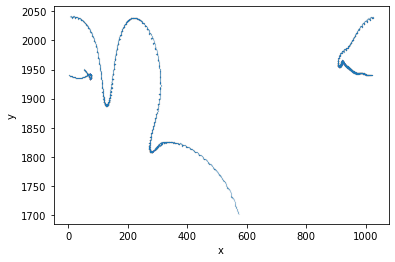

In [11]:
df.plot(x='x',y='y', kind='scatter', s=0.001)

In [13]:
sdr.mean_position(df, L)

(104.19882827429669, 1931.0729616583335)

10.000004444753099

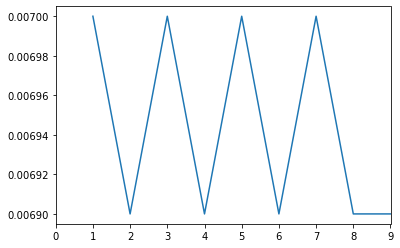

In [14]:
# illustrates variations in drifter time steps
df.sort_values('time').reset_index()['time'].diff().iloc[:10].plot()
df.sort_values('time').reset_index()['time'].diff().mean(axis=0)*24*60

---

## compute lagged autocorrelations

In [15]:
# myfun = correlate

def correlate(v1, v2, N, dt=None, detrend=False):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not Provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    if dt is None:
        dt = v1.reset_index()['index'].diff().mean()
    if detrend:
        print('!!! Not implemented yet')
        # https://www.machinelearningplus.com/time-series/time-series-analysis-python/
        return
    if v1 is None and v2 is None:
        _v1 = np.random.randn(N*2)
        _v2 = np.random.randn(N*2)
        vv = np.correlate(_v1, _v2, mode='same')
    else:
        vv = np.correlate(v1, v2, mode='same')
    return pd.Series(vv[int(vv.size/2):][:N], index=np.arange(N)*dt)

In [18]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!

# apply to one drifter
out = time_window_processing(df, correlate, ['u','u'], T, int(T/dt/2), dt=dt)
out

,x,y,0.0,0.006944444444444444,0.013888888888888888,0.020833333333333332,0.027777777777777776,0.034722222222222224,0.041666666666666664,0.048611111111111105,...,9.930555555555555,9.9375,9.944444444444445,9.951388888888888,9.958333333333332,9.965277777777777,9.972222222222221,9.979166666666666,9.98611111111111,9.993055555555555
1510.0069,1022.866620,1942.883560,65.251869,65.177638,65.013483,64.760598,64.420893,63.996975,63.492120,62.910239,...,7.863769,7.845620,7.827826,7.810430,7.793617,7.777455,7.762074,7.747558,7.733979,7.721396
1520.0069,945.092028,1953.198851,47.232007,47.084827,46.656915,45.951732,44.974970,43.734547,42.240565,40.505058,...,-7.380873,-8.143376,-8.811782,-9.380902,-9.846278,-10.204342,-10.452347,-10.588415,-10.611556,-10.521676
1530.0069,930.432523,1974.050691,66.227718,65.944984,65.349707,64.447026,63.244496,61.752081,59.982086,57.948897,...,-5.357273,-5.042035,-4.718391,-4.389179,-4.057250,-3.725420,-3.396444,-3.073052,-2.757811,-2.453213
1540.0069,1012.620378,1995.372894,99.107861,98.961982,98.533658,97.826896,96.848221,95.606576,94.113217,92.381547,...,20.439486,20.177057,19.891455,19.584442,19.257886,18.913774,18.554453,18.182285,17.799725,17.409376
1550.0069,96.897904,1952.648187,81.597356,81.310837,80.713881,79.812500,78.615722,77.135373,75.385877,73.384015,...,16.010823,15.934369,15.806114,15.624658,15.391974,15.109469,14.778959,14.402642,13.983073,13.523118
1560.0069,157.918396,1953.855647,55.384985,55.230151,54.837984,54.213168,53.361381,52.290362,51.009768,49.531010,...,12.036691,11.537153,11.009619,10.457756,9.885327,9.296136,8.694093,8.083159,7.467371,6.850908
1570.0069,239.144614,1976.728432,90.560978,90.351021,89.741572,88.738504,87.351371,85.593129,83.480054,81.031455,...,-0.036528,0.319496,0.678451,1.038236,1.396776,1.752031,2.102004,2.444699,2.778175,3.100491
1580.0069,288.544081,1884.823073,84.510859,84.193956,83.395010,82.121303,80.384586,78.201207,75.590215,72.575067,...,12.234099,11.842708,11.277649,10.543371,9.645980,8.592904,7.393016,6.056390,4.594302,3.019128


### map the computation for each drifter

In [19]:
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
df_chunked = dr.df.groupby(['id']).apply(time_window_processing, correlate, ['u','u'], T, int(T/dt/2), dt=dt)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  


In [20]:
df_chunked 

Dask DataFrame Structure:
                       x        y      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888888888 1.5208333

In [21]:
# inspect one partition
df_chunked.get_partition(0).compute()

x            y         0.0  0.006944444444444444  \
id                                                                          
22   1510.0069  111.220082   820.643731   16.376966             16.351358   
     1520.0069  121.384007   852.922447   14.136725             14.095598   
     1530.0069   92.183922   814.074864   13.634847             13.599289   
     1540.0069   83.128593   841.068939   15.383405             15.335511   
     1550.0069  109.590473   915.955326   16.115293             16.070653   
...                    ...          ...         ...                   ...   
8503 1540.0069  773.300155  1319.016472  262.491393            262.223087   
     1550.0069   33.615855  1323.962432  725.091199            724.705778   
     1560.0069  134.450006  1376.517990  662.577706            662.171967   
     1570.0069   53.024335  1393.058551  126.068903            125.586968   
     1580.0069  973.706463  1374.973514  171.631329            171.518870   

                0.013888888888888888  0.020833333333333332  \
id                                                           
22   1510.0069             16.283863             16.174975   
     1520.0069             13.985287             13.806655   
     1530.0069             13.498939             13.334640   
     1540.0069             15.206402             14.997120   
     1550.0069             15.940577             15.726181   
...                              ...                   ...   
8503 1540.0069            261.790443            261.196168   
     1550.0069            724.027754            723.061343   
     1560.0069            661.262146            659.854937   
     1570.0069            124.678761            123.349555   
     1580.0069            171.224732            170.750861   

                0.027777777777777776  0.034722222222222224  \
id                                                           
22   1510.0069             16.025487             15.836493   
     1520.0069             13.561088             13.250485   
     1530.0069             13.107740             12.820085   
     1540.0069             14.709330             14.345296   
     1550.0069             15.429269             15.052307   
...                              ...                   ...   
8503 1540.0069            260.444402            259.540655   
     1550.0069            721.814695            720.298403   
     1560.0069            657.963799            655.603596   
     1570.0069            121.608485            119.468416   
     1580.0069            170.101204            169.281418   

                0.041666666666666664  0.048611111111111105  ...  \
id                                                          ...   
22   1510.0069             15.609373             15.345787  ...   
     1520.0069             12.877244             12.444282  ...   
     1530.0069             12.473996             12.072256  ...   
     1540.0069             13.907863             13.400431  ...   
     1550.0069             14.598401             14.071260  ...   
...                              ...                   ...  ...   
8503 1540.0069            258.491378            257.305108  ...   
     1550.0069            718.527776            716.516404  ...   
     1560.0069            652.794163            649.558812  ...   
     1570.0069            116.944231            114.049817  ...   
     1580.0069            168.297964            167.158861  ...   

                9.930555555555555      9.9375  9.944444444444445  \
id                                                                 
22   1510.0069           1.473249    1.335886           1.201973   
     1520.0069          -1.289542   -1.250167          -1.206268   
     1530.0069           0.500530    0.380707           0.263309   
     1540.0069          -0.210789   -0.387598          -0.565812   
     1550.0069           1.087285    1.119515           1.148983   
...                           ...         ...                

In [22]:
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

# show one partition:
#df_chunked.get_partition(0).compute()

# inspect df_chunked
df_chunked

Dask DataFrame Structure:
                  time        x        y      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888888888 1.

### bin along y and sum

In [23]:
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
df_chunked

Dask DataFrame Structure:
                  time        x        y      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888888888 1.

In [24]:
uu = df_chunked.groupby(['y_cut']).sum().compute()

In [26]:
uu.head()

,time,x,y,0.0,0.006944444444444444,0.013888888888888888,0.020833333333333332,0.027777777777777776,0.034722222222222224,0.041666666666666664,...,9.930555555555555,9.9375,9.944444444444445,9.951388888888888,9.958333333333332,9.965277777777777,9.972222222222221,9.979166666666666,9.98611111111111,9.993055555555555
y_cut,,,,,,,,,,,,,,,,,,,,,
"(0, 50]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(50, 100]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(100, 150]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(150, 200]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(200, 250]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# transform into 2D xarray
# column header need to be transformed into indices
ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='lag')
      .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})
      .set_index(['y_bins','lag'])
      .to_xarray()
     )

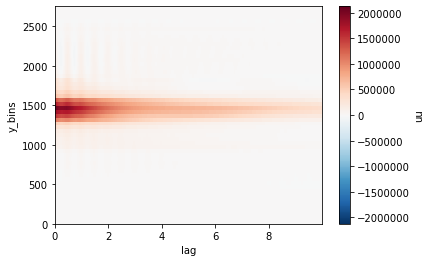

In [28]:
ds['uu'].plot()

In [29]:
ds

<xarray.Dataset>
Dimensions:  (lag: 1440, y_bins: 55)
Coordinates:
  * y_bins   (y_bins) float64 25.0 75.0 125.0 ... 2.625e+03 2.675e+03 2.725e+03
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993
Data variables:
    uu       (y_bins, lag) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

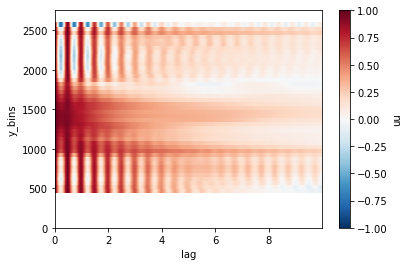

In [31]:
(ds['uu']/ds['uu'].sel(lag=0.)).plot()

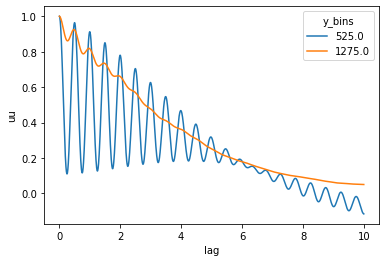

In [39]:
#(ds['uu']/ds['uu'].sel(lag=0.)).sel(y_bins=600, method='nearest').plot.line(x='lag')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=[10,25]).plot.line(x='lag')

In [78]:
# do all at once (with apply_twin_processing):

#df_chunked = dr.df.groupby(['id']).apply(time_window_processing, correlate, ['u','u'], T, int(T/dt/2), dt=dt)
#df_chunked = (
#              df_chunked.map_partitions(
#                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
#                                       )
#              )

df_chunked = apply_twin_processing(dr, correlate, ['u','u'], T, int(T/dt/2), dt=dt)

# bin sum
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
uu = df_chunked.groupby(['y_cut']).sum().compute()

ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='lag')
      .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})
      .set_index(['y_bins','lag'])
      .to_xarray()
     )

ds

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  import sys


<xarray.Dataset>
Dimensions:  (lag: 720, y_bins: 55)
Coordinates:
  * y_bins   (y_bins) float64 25.0 75.0 125.0 ... 2.625e+03 2.675e+03 2.725e+03
  * lag      (lag) float64 -72.0 -71.8 -71.6 -71.4 -71.2 ... 71.2 71.4 71.6 71.8
Data variables:
    uu       (y_bins, lag) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

---
## compute spectra

In [79]:
from scipy import signal

def get_spectrum(v, N, dt=None, method='welch', detrend='linear', **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v: ndarray, pd.Series
            Time series, the index must be time if dt is not provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
        
        method: string
            Method that will be employed for spectral calculations.
            Default is 'welch'
            
        detrend: boolean, optional
            Turns detrending on or off. Default is 'linear'.

    See: 
        - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
        - https://krischer.github.io/mtspec/
        - http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    '''
    if v is None:
        _v = np.random.randn(N)
    else:
        _v = v.iloc[:N]
    if dt is None:
        dt = _v.reset_index()['index'].diff().mean()
    if detrend and not method=='welch':
        print('!!! Not implemented yet except for welch')    
    if method=='welch':
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(_v, fs=1/dt, axis=0, **dkwargs)
    elif method=='mtspec':
        lE, f = mtspec(data=_v, delta=dt, time_bandwidth=4.,
                       number_of_tapers=6, quadratic=True)
    elif method=='mt':
        dkwargs = {'NW': 2, 'sides': 'twosided', 
                   'adaptive': False, 'jackknife': False}
        dkwargs.update(kwargs)
        lf, E, nu = tsa.multi_taper_psd(_v, Fs=1/dt, **dkwargs)
        f = fftfreq(len(lf))*24.
        #print('Number of tapers = %d' %(nu[0]/2))
    return pd.Series(E, index=f)

In [80]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!

# apply to one drifter
out = time_window_processing(df, get_spectrum, ['u'], T, int(T/dt), dt=dt)
out

,x,y,0.0,0.05,0.1,0.15000000000000002,0.2,0.25,0.30000000000000004,0.35000000000000003,...,-0.5,-0.45,-0.4,-0.35000000000000003,-0.30000000000000004,-0.25,-0.2,-0.15000000000000002,-0.1,-0.05
1510.0069,1022.866620,1942.883560,0.036925,0.054550,0.036240,0.013092,4.672875e-03,1.719899e-03,4.622211e-04,8.235068e-05,...,2.064090e-05,8.198100e-06,3.040081e-06,8.235068e-05,4.622211e-04,1.719899e-03,4.672875e-03,0.013092,0.036240,0.054550
1520.0069,945.092028,1953.198851,0.000003,0.000350,0.000582,0.000051,6.034404e-06,2.172208e-06,5.851528e-07,1.767223e-08,...,8.454176e-07,1.278183e-07,5.763610e-09,1.767223e-08,5.851528e-07,2.172208e-06,6.034404e-06,0.000051,0.000582,0.000350
1530.0069,930.432523,1974.050691,0.005841,0.011148,0.011872,0.002962,4.067160e-04,1.676648e-04,9.751096e-05,5.861940e-05,...,3.140742e-06,9.798527e-06,2.899292e-05,5.861940e-05,9.751096e-05,1.676648e-04,4.067160e-04,0.002962,0.011872,0.011148
1540.0069,1012.620378,1995.372894,0.029927,0.021478,0.004275,0.001541,2.107768e-04,1.112478e-04,4.794747e-05,1.882733e-05,...,3.420812e-06,4.308109e-06,2.070280e-05,1.882733e-05,4.794747e-05,1.112478e-04,2.107768e-04,0.001541,0.004275,0.021478
1550.0069,96.897904,1952.648187,0.007813,0.010905,0.005191,0.000198,6.402210e-06,4.298824e-06,5.005793e-07,6.657855e-07,...,1.338824e-07,1.776727e-07,5.774460e-09,6.657855e-07,5.005793e-07,4.298824e-06,6.402210e-06,0.000198,0.005191,0.010905
1560.0069,157.918396,1953.855647,0.003285,0.003602,0.001064,0.000005,3.695526e-06,9.248095e-07,9.561899e-08,2.864084e-07,...,1.332746e-07,3.784806e-08,3.621719e-08,2.864084e-07,9.561899e-08,9.248095e-07,3.695526e-06,0.000005,0.001064,0.003602
1570.0069,239.144614,1976.728432,0.038920,0.041763,0.012872,0.000197,4.909354e-07,1.602136e-06,1.731420e-06,1.766166e-08,...,1.064692e-06,1.044300e-06,3.487218e-07,1.766166e-08,1.731420e-06,1.602136e-06,4.909354e-07,0.000197,0.012872,0.041763
1580.0069,288.544081,1884.823073,0.048232,0.053420,0.017781,0.000172,3.380592e-05,6.583916e-06,4.880470e-07,6.411863e-07,...,5.852334e-07,1.965939e-08,1.009838e-07,6.411863e-07,4.880470e-07,6.583916e-06,3.380592e-05,0.000172,0.017781,0.053420


In [81]:
# run computation over the whole dateset

df_chunked = apply_twin_processing(dr, get_spectrum, ['u'], T, int(T/dt/2), dt=dt)

# bin sum
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
Eu = df_chunked.groupby(['y_cut']).mean().compute()

ds = (pd.melt(Eu.set_index(Eu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='frequency')
      .rename(columns={'y_cut': 'y_bins', 'value': 'Eu'})
      .set_index(['y_bins','frequency'])
      .to_xarray()
     )

ds

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  import sys


<xarray.Dataset>
Dimensions:    (frequency: 1440, y_bins: 55)
Coordinates:
  * y_bins     (y_bins) float64 25.0 75.0 125.0 ... 2.675e+03 2.725e+03
  * frequency  (frequency) float64 -72.0 -71.9 -71.8 -71.7 ... 71.7 71.8 71.9
Data variables:
    Eu         (y_bins, frequency) float64 nan nan nan nan ... nan nan nan nan

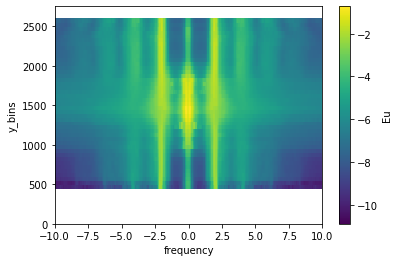

In [82]:
np.log10(ds.Eu).plot(x='frequency',y='y_bins',xlim=(-10,10))

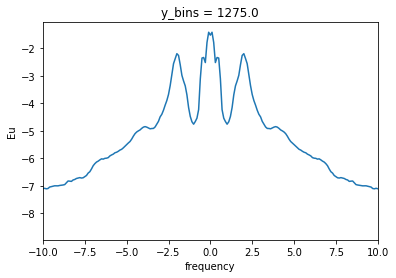

In [98]:

# not working know, I am not sure why
#np.log10(ds.Eu.sel(y_bins=1500, method='nearest')).plot(x='frequency', xlim=(-10,10))

np.log10(ds.Eu.isel(y_bins=25)).plot(x='frequency', xlim=(-10,10))

---

In [40]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli